# 06 LightGBM: Optunaあり vs なし

`00_prepare_data.ipynb` で作成した Titanic の Train/Test を使い、
- PatternA: 固定ハイパーパラメータ（Optunaなし）
- PatternB: Optunaでハイパーパラメータ探索
を比較します。

In [75]:
import os
import random
import warnings
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, log_loss, roc_auc_score

try:
    import optuna
except ImportError as exc:
    raise ImportError('optuna が未インストールです。`uv pip install optuna` を実行してください。') from exc

warnings.filterwarnings('ignore')

SEED = 42
N_SPLITS = 5
N_TRIALS = 30
TIMEOUT_SEC = 300

os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

In [76]:
train_df = pd.read_csv('data/processed/classification_train.csv')
test_df = pd.read_csv('data/processed/classification_test.csv')

X_train_full = train_df.drop(columns=['target'])
y_train_full = train_df['target'].astype(int)
X_test = test_df.drop(columns=['target'])
y_test = test_df['target'].astype(int)

class_labels = np.sort(y_train_full.unique())
num_class = len(class_labels)
is_binary = num_class == 2

print(f'Train shape: {X_train_full.shape}')
print(f'Test shape : {X_test.shape}')
print(f'Classes    : {class_labels.tolist()}')

Train shape: (19536, 14)
Test shape : (29306, 14)
Classes    : [0, 1]


In [77]:
def make_lgbm_params(seed, custom_params=None):
    base_params = {
        'n_estimators': 300,
        'learning_rate': 0.05,
        'num_leaves': 31,
        'min_child_samples': 20,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'reg_alpha': 0.0,
        'reg_lambda': 1.0,
        'random_state': seed,
        'bagging_seed': seed,
        'feature_fraction_seed': seed,
        'data_random_seed': seed,
        'deterministic': True,
        'force_col_wise': True
    }

    if is_binary:
        base_params.update({
            'objective': 'binary'
        })
    else:
        base_params.update({
            'objective': 'multiclass',
            'num_class': num_class
        })

    if custom_params is not None:
        base_params.update(custom_params)

    return base_params

def calc_auc(y_true, proba):
    if is_binary:
        return roc_auc_score(y_true, proba[:, 1])
    return roc_auc_score(y_true, proba, multi_class='ovr', average='macro')

def evaluate_pattern(method_name, custom_params=None):
    skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
    fold_rows = []
    test_proba_folds = []

    for fold, (tr_idx, va_idx) in enumerate(skf.split(X_train_full, y_train_full), start=1):
        X_tr = X_train_full.iloc[tr_idx]
        y_tr = y_train_full.iloc[tr_idx]
        X_va = X_train_full.iloc[va_idx]
        y_va = y_train_full.iloc[va_idx]

        params = make_lgbm_params(SEED + fold, custom_params=custom_params)
        model = lgb.LGBMClassifier(**params)
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_va, y_va)],
            eval_metric='binary_logloss' if is_binary else 'multi_logloss',
            callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
        )

        tr_proba = model.predict_proba(X_tr)
        tr_pred = model.predict(X_tr)
        va_proba = model.predict_proba(X_va)
        va_pred = model.predict(X_va)
        te_proba = model.predict_proba(X_test)
        te_pred = np.argmax(te_proba, axis=1)

        test_proba_folds.append(te_proba)

        for metrics in [
            {
                'Split': 'Train',
                'Accuracy': accuracy_score(y_tr, tr_pred),
                'F1_macro': f1_score(y_tr, tr_pred, average='macro'),
                'LogLoss': log_loss(y_tr, tr_proba, labels=class_labels),
                'AUC': calc_auc(y_tr, tr_proba)
            },
            {
                'Split': 'Valid',
                'Accuracy': accuracy_score(y_va, va_pred),
                'F1_macro': f1_score(y_va, va_pred, average='macro'),
                'LogLoss': log_loss(y_va, va_proba, labels=class_labels),
                'AUC': calc_auc(y_va, va_proba)
            },
            {
                'Split': 'Test',
                'Accuracy': accuracy_score(y_test, te_pred),
                'F1_macro': f1_score(y_test, te_pred, average='macro'),
                'LogLoss': log_loss(y_test, te_proba, labels=class_labels),
                'AUC': calc_auc(y_test, te_proba)
            }
        ]:
            fold_rows.append({
                'Method': method_name,
                'Fold': fold,
                'Split': metrics['Split'],
                'Accuracy': metrics['Accuracy'],
                'F1_macro': metrics['F1_macro'],
                'LogLoss': metrics['LogLoss'],
                'AUC': metrics['AUC']
            })

    fold_df = pd.DataFrame(fold_rows)
    mean_df = fold_df.groupby(['Method', 'Split'], as_index=False)[['Accuracy', 'F1_macro', 'LogLoss', 'AUC']].mean()

    test_proba_mean = np.mean(np.stack(test_proba_folds, axis=0), axis=0)
    test_pred_mean = np.argmax(test_proba_mean, axis=1)

    return fold_df, mean_df, test_pred_mean, test_proba_mean

In [78]:
def optuna_objective(trial):
    trial_params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 600),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 8, 128),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 80),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True)
    }

    skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
    fold_losses = []

    for fold, (tr_idx, va_idx) in enumerate(skf.split(X_train_full, y_train_full), start=1):
        X_tr = X_train_full.iloc[tr_idx]
        y_tr = y_train_full.iloc[tr_idx]
        X_va = X_train_full.iloc[va_idx]
        y_va = y_train_full.iloc[va_idx]

        params = make_lgbm_params(SEED + fold, custom_params=trial_params)
        model = lgb.LGBMClassifier(**params)
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_va, y_va)],
            eval_metric='binary_logloss' if is_binary else 'multi_logloss',
            callbacks=[lgb.early_stopping(stopping_rounds=30, verbose=False)]
        )

        va_proba = model.predict_proba(X_va)
        fold_loss = log_loss(y_va, va_proba, labels=class_labels)
        fold_losses.append(fold_loss)

    return float(np.mean(fold_losses))

In [79]:
baseline_fold_df, baseline_summary_df, baseline_test_pred, baseline_test_proba = evaluate_pattern(
    method_name='NoOptuna(FixedParams)',
    custom_params=None
)

study = optuna.create_study(direction='minimize', study_name='lgbm_optuna_vs_no_optuna')
study.optimize(optuna_objective, n_trials=N_TRIALS, timeout=TIMEOUT_SEC, show_progress_bar=False)

best_params = study.best_trial.params
print('Best trial:', study.best_trial.number)
print('Best valid logloss:', study.best_value)
print('Best params:')
print(best_params)

[LightGBM] [Info] Number of positive: 3740, number of negative: 11888
[LightGBM] [Info] Total Bins 669
[LightGBM] [Info] Number of data points in the train set: 15628, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239314 -> initscore=-1.156444
[LightGBM] [Info] Start training from score -1.156444
[LightGBM] [Info] Number of positive: 3740, number of negative: 11889
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 15629, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239299 -> initscore=-1.156528
[LightGBM] [Info] Start training from score -1.156528
[LightGBM] [Info] Number of positive: 3740, number of negative: 11889
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 15629, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239299 -> initscore=-1.156528
[LightGBM] [Info] Start training from score -1.156528
[LightGBM]

[I 2026-02-20 16:48:34,766] A new study created in memory with name: lgbm_optuna_vs_no_optuna


[LightGBM] [Info] Number of positive: 3740, number of negative: 11888
[LightGBM] [Info] Total Bins 669
[LightGBM] [Info] Number of data points in the train set: 15628, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239314 -> initscore=-1.156444
[LightGBM] [Info] Start training from score -1.156444
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2026-02-20 16:48:40,318] Trial 0 finished with value: 0.2906252862761691 and parameters: {'n_estimators': 465, 'learning_rate': 0.040593731829724554, 'num_leaves': 117, 'min_child_samples': 70, 'subsample': 0.8834787702202254, 'colsample_bytree': 0.7451312322613973, 'reg_alpha': 4.521620606250671e-06, 'reg_lambda': 4.549274853361652}. Best is trial 0 with value: 0.2906252862761691.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 3740, number of negative: 11888
[LightGBM] [Info] Total Bins 669
[LightGBM] [Info] Number of data points in the train set: 15628, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239314 -> initscore=-1.156444
[LightGBM] [Info] Start training from score -1.156444
[LightGBM] [Info] Number of positive: 3740, number of negative: 11889
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 15629, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239299 -> initscore=-1.156528
[LightGBM] [Info] Start training from score -1.156528
[LightGBM] [Info] Number of positive: 3740, number of negative: 11889
[LightGBM] [Info] Total Bins 667
[LightGBM] [

[I 2026-02-20 16:48:46,620] Trial 1 finished with value: 0.28689464678030036 and parameters: {'n_estimators': 223, 'learning_rate': 0.022331611793196066, 'num_leaves': 91, 'min_child_samples': 8, 'subsample': 0.7511154629960948, 'colsample_bytree': 0.7576752964847797, 'reg_alpha': 0.44034958149128756, 'reg_lambda': 0.018448777700593222}. Best is trial 1 with value: 0.28689464678030036.


[LightGBM] [Info] Number of positive: 3740, number of negative: 11888
[LightGBM] [Info] Total Bins 669
[LightGBM] [Info] Number of data points in the train set: 15628, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239314 -> initscore=-1.156444
[LightGBM] [Info] Start training from score -1.156444
[LightGBM] [Info] Number of positive: 3740, number of negative: 11889
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 15629, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239299 -> initscore=-1.156528
[LightGBM] [Info] Start training from score -1.156528
[LightGBM] [Info] Number of positive: 3740, number of negative: 11889
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 15629, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239299 -> initscore=-1.156528
[LightGBM] [Info] Start training from score -1.156528
[LightGBM]

[I 2026-02-20 16:48:49,165] Trial 2 finished with value: 0.2891999092630334 and parameters: {'n_estimators': 535, 'learning_rate': 0.11203339059517219, 'num_leaves': 93, 'min_child_samples': 42, 'subsample': 0.9160385530571394, 'colsample_bytree': 0.6560475208497415, 'reg_alpha': 9.510682412487011e-07, 'reg_lambda': 3.6148972734073364e-05}. Best is trial 1 with value: 0.28689464678030036.


[LightGBM] [Info] Number of positive: 3740, number of negative: 11888
[LightGBM] [Info] Total Bins 669
[LightGBM] [Info] Number of data points in the train set: 15628, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239314 -> initscore=-1.156444
[LightGBM] [Info] Start training from score -1.156444
[LightGBM] [Info] Number of positive: 3740, number of negative: 11889
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 15629, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239299 -> initscore=-1.156528
[LightGBM] [Info] Start training from score -1.156528
[LightGBM] [Info] Number of positive: 3740, number of negative: 11889
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 15629, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239299 -> initscore=-1.156528
[LightGBM] [Info] Start training from score -1.156528
[LightGBM]

[I 2026-02-20 16:48:51,814] Trial 3 finished with value: 0.28375550652207127 and parameters: {'n_estimators': 298, 'learning_rate': 0.057667786950729445, 'num_leaves': 43, 'min_child_samples': 20, 'subsample': 0.6486954697961916, 'colsample_bytree': 0.8024560769313318, 'reg_alpha': 9.309909645200098e-05, 'reg_lambda': 7.131050644334982e-06}. Best is trial 3 with value: 0.28375550652207127.


[LightGBM] [Info] Number of positive: 3740, number of negative: 11888
[LightGBM] [Info] Total Bins 669
[LightGBM] [Info] Number of data points in the train set: 15628, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239314 -> initscore=-1.156444
[LightGBM] [Info] Start training from score -1.156444
[LightGBM] [Info] Number of positive: 3740, number of negative: 11889
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 15629, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239299 -> initscore=-1.156528
[LightGBM] [Info] Start training from score -1.156528
[LightGBM] [Info] Number of positive: 3740, number of negative: 11889
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 15629, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239299 -> initscore=-1.156528
[LightGBM] [Info] Start training from score -1.156528
[LightGBM]

[I 2026-02-20 16:48:53,480] Trial 4 finished with value: 0.2853672146494864 and parameters: {'n_estimators': 244, 'learning_rate': 0.13435433645841616, 'num_leaves': 30, 'min_child_samples': 25, 'subsample': 0.881046576838422, 'colsample_bytree': 0.9395131339494183, 'reg_alpha': 0.00017750719056099115, 'reg_lambda': 4.611258149869271e-05}. Best is trial 3 with value: 0.28375550652207127.


[LightGBM] [Info] Number of positive: 3740, number of negative: 11888
[LightGBM] [Info] Total Bins 669
[LightGBM] [Info] Number of data points in the train set: 15628, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239314 -> initscore=-1.156444
[LightGBM] [Info] Start training from score -1.156444
[LightGBM] [Info] Number of positive: 3740, number of negative: 11889
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 15629, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239299 -> initscore=-1.156528
[LightGBM] [Info] Start training from score -1.156528
[LightGBM] [Info] Number of positive: 3740, number of negative: 11889
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 15629, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239299 -> initscore=-1.156528
[LightGBM] [Info] Start training from score -1.156528
[LightGBM]

[I 2026-02-20 16:48:59,312] Trial 5 finished with value: 0.2967258879807258 and parameters: {'n_estimators': 222, 'learning_rate': 0.01591566658603101, 'num_leaves': 82, 'min_child_samples': 66, 'subsample': 0.7657220632119471, 'colsample_bytree': 0.8371806859817134, 'reg_alpha': 8.450140904873919e-06, 'reg_lambda': 0.04732185359143848}. Best is trial 3 with value: 0.28375550652207127.


[LightGBM] [Info] Number of positive: 3740, number of negative: 11888
[LightGBM] [Info] Total Bins 669
[LightGBM] [Info] Number of data points in the train set: 15628, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239314 -> initscore=-1.156444
[LightGBM] [Info] Start training from score -1.156444
[LightGBM] [Info] Number of positive: 3740, number of negative: 11889
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 15629, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239299 -> initscore=-1.156528
[LightGBM] [Info] Start training from score -1.156528
[LightGBM] [Info] Number of positive: 3740, number of negative: 11889
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 15629, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239299 -> initscore=-1.156528
[LightGBM] [Info] Start training from score -1.156528
[LightGBM]

[I 2026-02-20 16:49:02,057] Trial 6 finished with value: 0.2875047945835171 and parameters: {'n_estimators': 412, 'learning_rate': 0.08286802213359534, 'num_leaves': 73, 'min_child_samples': 27, 'subsample': 0.8668483039913969, 'colsample_bytree': 0.8535608369327081, 'reg_alpha': 0.9455159643057233, 'reg_lambda': 0.0002774632266516944}. Best is trial 3 with value: 0.28375550652207127.


[LightGBM] [Info] Number of positive: 3740, number of negative: 11888
[LightGBM] [Info] Total Bins 669
[LightGBM] [Info] Number of data points in the train set: 15628, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239314 -> initscore=-1.156444
[LightGBM] [Info] Start training from score -1.156444
[LightGBM] [Info] Number of positive: 3740, number of negative: 11889
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 15629, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239299 -> initscore=-1.156528
[LightGBM] [Info] Start training from score -1.156528
[LightGBM] [Info] Number of positive: 3740, number of negative: 11889
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 15629, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239299 -> initscore=-1.156528
[LightGBM] [Info] Start training from score -1.156528
[LightGBM]

[I 2026-02-20 16:49:04,687] Trial 7 finished with value: 0.2925544249109241 and parameters: {'n_estimators': 345, 'learning_rate': 0.10018211892352298, 'num_leaves': 113, 'min_child_samples': 46, 'subsample': 0.7571561945301667, 'colsample_bytree': 0.9982542855137423, 'reg_alpha': 5.056665661492334e-07, 'reg_lambda': 0.0011425706350837253}. Best is trial 3 with value: 0.28375550652207127.


[LightGBM] [Info] Number of positive: 3740, number of negative: 11888
[LightGBM] [Info] Total Bins 669
[LightGBM] [Info] Number of data points in the train set: 15628, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239314 -> initscore=-1.156444
[LightGBM] [Info] Start training from score -1.156444
[LightGBM] [Info] Number of positive: 3740, number of negative: 11889
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 15629, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239299 -> initscore=-1.156528
[LightGBM] [Info] Start training from score -1.156528
[LightGBM] [Info] Number of positive: 3740, number of negative: 11889
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 15629, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239299 -> initscore=-1.156528
[LightGBM] [Info] Start training from score -1.156528
[LightGBM]

[I 2026-02-20 16:49:07,622] Trial 8 finished with value: 0.3053814811556008 and parameters: {'n_estimators': 179, 'learning_rate': 0.01510313175984086, 'num_leaves': 39, 'min_child_samples': 38, 'subsample': 0.6967571422007394, 'colsample_bytree': 0.6988497360991459, 'reg_alpha': 0.619680103333132, 'reg_lambda': 0.02772478567694382}. Best is trial 3 with value: 0.28375550652207127.


[LightGBM] [Info] Number of positive: 3740, number of negative: 11888
[LightGBM] [Info] Total Bins 669
[LightGBM] [Info] Number of data points in the train set: 15628, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239314 -> initscore=-1.156444
[LightGBM] [Info] Start training from score -1.156444
[LightGBM] [Info] Number of positive: 3740, number of negative: 11889
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 15629, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239299 -> initscore=-1.156528
[LightGBM] [Info] Start training from score -1.156528
[LightGBM] [Info] Number of positive: 3740, number of negative: 11889
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 15629, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239299 -> initscore=-1.156528
[LightGBM] [Info] Start training from score -1.156528
[LightGBM]

[I 2026-02-20 16:49:09,239] Trial 9 finished with value: 0.29999813375201645 and parameters: {'n_estimators': 133, 'learning_rate': 0.027236162823289518, 'num_leaves': 19, 'min_child_samples': 49, 'subsample': 0.6475692778273117, 'colsample_bytree': 0.7378258017541025, 'reg_alpha': 0.010640440799733976, 'reg_lambda': 1.584683131825935e-05}. Best is trial 3 with value: 0.28375550652207127.


[LightGBM] [Info] Number of positive: 3740, number of negative: 11888
[LightGBM] [Info] Total Bins 669
[LightGBM] [Info] Number of data points in the train set: 15628, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239314 -> initscore=-1.156444
[LightGBM] [Info] Start training from score -1.156444
[LightGBM] [Info] Number of positive: 3740, number of negative: 11889
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 15629, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239299 -> initscore=-1.156528
[LightGBM] [Info] Start training from score -1.156528
[LightGBM] [Info] Number of positive: 3740, number of negative: 11889
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 15629, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239299 -> initscore=-1.156528
[LightGBM] [Info] Start training from score -1.156528
[LightGBM]

[I 2026-02-20 16:49:12,664] Trial 10 finished with value: 0.2828402145348072 and parameters: {'n_estimators': 333, 'learning_rate': 0.05418702247439193, 'num_leaves': 52, 'min_child_samples': 8, 'subsample': 0.6148151971385892, 'colsample_bytree': 0.6183624108053116, 'reg_alpha': 2.0732591179532584e-08, 'reg_lambda': 3.131493969602774e-07}. Best is trial 10 with value: 0.2828402145348072.


[LightGBM] [Info] Number of positive: 3740, number of negative: 11888
[LightGBM] [Info] Total Bins 669
[LightGBM] [Info] Number of data points in the train set: 15628, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239314 -> initscore=-1.156444
[LightGBM] [Info] Start training from score -1.156444
[LightGBM] [Info] Number of positive: 3740, number of negative: 11889
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 15629, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239299 -> initscore=-1.156528
[LightGBM] [Info] Start training from score -1.156528
[LightGBM] [Info] Number of positive: 3740, number of negative: 11889
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 15629, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239299 -> initscore=-1.156528
[LightGBM] [Info] Start training from score -1.156528
[LightGBM]

[I 2026-02-20 16:49:17,083] Trial 11 finished with value: 0.28285686221771805 and parameters: {'n_estimators': 335, 'learning_rate': 0.05452816710022316, 'num_leaves': 54, 'min_child_samples': 7, 'subsample': 0.6381543200250853, 'colsample_bytree': 0.6362388077203682, 'reg_alpha': 8.137528199208804e-08, 'reg_lambda': 4.257159745197387e-08}. Best is trial 10 with value: 0.2828402145348072.


[LightGBM] [Info] Number of positive: 3740, number of negative: 11888
[LightGBM] [Info] Total Bins 669
[LightGBM] [Info] Number of data points in the train set: 15628, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239314 -> initscore=-1.156444
[LightGBM] [Info] Start training from score -1.156444
[LightGBM] [Info] Number of positive: 3740, number of negative: 11889
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 15629, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239299 -> initscore=-1.156528
[LightGBM] [Info] Start training from score -1.156528
[LightGBM] [Info] Number of positive: 3740, number of negative: 11889
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 15629, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239299 -> initscore=-1.156528
[LightGBM] [Info] Start training from score -1.156528
[LightGBM]

[I 2026-02-20 16:49:21,807] Trial 12 finished with value: 0.28273745510205817 and parameters: {'n_estimators': 401, 'learning_rate': 0.050241289258927374, 'num_leaves': 60, 'min_child_samples': 6, 'subsample': 0.607293588260076, 'colsample_bytree': 0.6041269199405257, 'reg_alpha': 1.4614377844063343e-08, 'reg_lambda': 1.2055866216717379e-08}. Best is trial 12 with value: 0.28273745510205817.


[LightGBM] [Info] Number of positive: 3740, number of negative: 11888
[LightGBM] [Info] Total Bins 669
[LightGBM] [Info] Number of data points in the train set: 15628, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239314 -> initscore=-1.156444
[LightGBM] [Info] Start training from score -1.156444
[LightGBM] [Info] Number of positive: 3740, number of negative: 11889
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 15629, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239299 -> initscore=-1.156528
[LightGBM] [Info] Start training from score -1.156528
[LightGBM] [Info] Number of positive: 3740, number of negative: 11889
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 15629, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239299 -> initscore=-1.156528
[LightGBM] [Info] Start training from score -1.156528
[LightGBM]

[I 2026-02-20 16:49:23,195] Trial 13 finished with value: 0.2863362123303672 and parameters: {'n_estimators': 427, 'learning_rate': 0.1942249441302525, 'num_leaves': 58, 'min_child_samples': 15, 'subsample': 0.62382662441534, 'colsample_bytree': 0.6067155894908579, 'reg_alpha': 1.205041453602258e-08, 'reg_lambda': 1.4714974767119046e-08}. Best is trial 12 with value: 0.28273745510205817.


[LightGBM] [Info] Number of positive: 3740, number of negative: 11888
[LightGBM] [Info] Total Bins 669
[LightGBM] [Info] Number of data points in the train set: 15628, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239314 -> initscore=-1.156444
[LightGBM] [Info] Start training from score -1.156444
[LightGBM] [Info] Number of positive: 3740, number of negative: 11889
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 15629, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239299 -> initscore=-1.156528
[LightGBM] [Info] Start training from score -1.156528
[LightGBM] [Info] Number of positive: 3740, number of negative: 11889
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 15629, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239299 -> initscore=-1.156528
[LightGBM] [Info] Start training from score -1.156528
[LightGBM]

[I 2026-02-20 16:49:29,213] Trial 14 finished with value: 0.28255807784699327 and parameters: {'n_estimators': 559, 'learning_rate': 0.035334702675807975, 'num_leaves': 65, 'min_child_samples': 5, 'subsample': 0.6013134930586377, 'colsample_bytree': 0.6813449232942006, 'reg_alpha': 1.2745215782856813e-08, 'reg_lambda': 3.822792099081491e-07}. Best is trial 14 with value: 0.28255807784699327.


[LightGBM] [Info] Number of positive: 3740, number of negative: 11888
[LightGBM] [Info] Total Bins 669
[LightGBM] [Info] Number of data points in the train set: 15628, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239314 -> initscore=-1.156444
[LightGBM] [Info] Start training from score -1.156444
[LightGBM] [Info] Number of positive: 3740, number of negative: 11889
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 15629, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239299 -> initscore=-1.156528
[LightGBM] [Info] Start training from score -1.156528
[LightGBM] [Info] Number of positive: 3740, number of negative: 11889
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 15629, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239299 -> initscore=-1.156528
[LightGBM] [Info] Start training from score -1.156528
[LightGBM]

[I 2026-02-20 16:49:34,529] Trial 15 finished with value: 0.2867542371509757 and parameters: {'n_estimators': 592, 'learning_rate': 0.032525985339934796, 'num_leaves': 69, 'min_child_samples': 59, 'subsample': 0.984708263265909, 'colsample_bytree': 0.6900833251933584, 'reg_alpha': 0.004987822669114498, 'reg_lambda': 5.677610835795586e-07}. Best is trial 14 with value: 0.28255807784699327.


[LightGBM] [Info] Number of positive: 3740, number of negative: 11888
[LightGBM] [Info] Total Bins 669
[LightGBM] [Info] Number of data points in the train set: 15628, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239314 -> initscore=-1.156444
[LightGBM] [Info] Start training from score -1.156444
[LightGBM] [Info] Number of positive: 3740, number of negative: 11889
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 15629, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239299 -> initscore=-1.156528
[LightGBM] [Info] Start training from score -1.156528
[LightGBM] [Info] Number of positive: 3740, number of negative: 11889
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 15629, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239299 -> initscore=-1.156528
[LightGBM] [Info] Start training from score -1.156528
[LightGBM]

[I 2026-02-20 16:49:38,485] Trial 16 finished with value: 0.2862621809969976 and parameters: {'n_estimators': 494, 'learning_rate': 0.02333401012751064, 'num_leaves': 11, 'min_child_samples': 80, 'subsample': 0.7082477347827287, 'colsample_bytree': 0.6817641651991246, 'reg_alpha': 3.235897726281591e-07, 'reg_lambda': 5.261334755527163e-07}. Best is trial 14 with value: 0.28255807784699327.


[LightGBM] [Info] Number of positive: 3740, number of negative: 11888
[LightGBM] [Info] Total Bins 669
[LightGBM] [Info] Number of data points in the train set: 15628, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239314 -> initscore=-1.156444
[LightGBM] [Info] Start training from score -1.156444
[LightGBM] [Info] Number of positive: 3740, number of negative: 11889
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 15629, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239299 -> initscore=-1.156528
[LightGBM] [Info] Start training from score -1.156528
[LightGBM] [Info] Number of positive: 3740, number of negative: 11889
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 15629, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239299 -> initscore=-1.156528
[LightGBM] [Info] Start training from score -1.156528
[LightGBM]

[I 2026-02-20 16:49:53,490] Trial 17 finished with value: 0.2853511174304256 and parameters: {'n_estimators': 586, 'learning_rate': 0.010313035020529368, 'num_leaves': 83, 'min_child_samples': 32, 'subsample': 0.6964999979329236, 'colsample_bytree': 0.6095168917732371, 'reg_alpha': 1.119048012544325e-05, 'reg_lambda': 1.092352608155723e-08}. Best is trial 14 with value: 0.28255807784699327.


[LightGBM] [Info] Number of positive: 3740, number of negative: 11888
[LightGBM] [Info] Total Bins 669
[LightGBM] [Info] Number of data points in the train set: 15628, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239314 -> initscore=-1.156444
[LightGBM] [Info] Start training from score -1.156444
[LightGBM] [Info] Number of positive: 3740, number of negative: 11889
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 15629, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239299 -> initscore=-1.156528
[LightGBM] [Info] Start training from score -1.156528
[LightGBM] [Info] Number of positive: 3740, number of negative: 11889
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 15629, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239299 -> initscore=-1.156528
[LightGBM] [Info] Start training from score -1.156528
[LightGBM]

[I 2026-02-20 16:49:57,131] Trial 18 finished with value: 0.28683248946054424 and parameters: {'n_estimators': 410, 'learning_rate': 0.0719924060023443, 'num_leaves': 101, 'min_child_samples': 17, 'subsample': 0.6020216566046899, 'colsample_bytree': 0.667249604450763, 'reg_alpha': 1.1131983333669773e-08, 'reg_lambda': 1.4798475299689957e-06}. Best is trial 14 with value: 0.28255807784699327.


[LightGBM] [Info] Number of positive: 3740, number of negative: 11888
[LightGBM] [Info] Total Bins 669
[LightGBM] [Info] Number of data points in the train set: 15628, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239314 -> initscore=-1.156444
[LightGBM] [Info] Start training from score -1.156444
[LightGBM] [Info] Number of positive: 3740, number of negative: 11889
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 15629, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239299 -> initscore=-1.156528
[LightGBM] [Info] Start training from score -1.156528
[LightGBM] [Info] Number of positive: 3740, number of negative: 11889
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 15629, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239299 -> initscore=-1.156528
[LightGBM] [Info] Start training from score -1.156528
[LightGBM]

[I 2026-02-20 16:50:01,634] Trial 19 finished with value: 0.28399257097644204 and parameters: {'n_estimators': 528, 'learning_rate': 0.03901268908496287, 'num_leaves': 63, 'min_child_samples': 15, 'subsample': 0.8073118738080323, 'colsample_bytree': 0.714292198024678, 'reg_alpha': 0.0016540631114142356, 'reg_lambda': 6.477945990465016e-08}. Best is trial 14 with value: 0.28255807784699327.


[LightGBM] [Info] Number of positive: 3740, number of negative: 11888
[LightGBM] [Info] Total Bins 669
[LightGBM] [Info] Number of data points in the train set: 15628, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239314 -> initscore=-1.156444
[LightGBM] [Info] Start training from score -1.156444
[LightGBM] [Info] Number of positive: 3740, number of negative: 11889
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 15629, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239299 -> initscore=-1.156528
[LightGBM] [Info] Start training from score -1.156528
[LightGBM] [Info] Number of positive: 3740, number of negative: 11889
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 15629, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239299 -> initscore=-1.156528
[LightGBM] [Info] Start training from score -1.156528
[LightGBM]

[I 2026-02-20 16:50:06,089] Trial 20 finished with value: 0.2827183474505309 and parameters: {'n_estimators': 446, 'learning_rate': 0.031813226549599206, 'num_leaves': 32, 'min_child_samples': 33, 'subsample': 0.6895806329372208, 'colsample_bytree': 0.6492118943810041, 'reg_alpha': 1.5941487373306058e-07, 'reg_lambda': 8.407543291638116e-08}. Best is trial 14 with value: 0.28255807784699327.


[LightGBM] [Info] Number of positive: 3740, number of negative: 11888
[LightGBM] [Info] Total Bins 669
[LightGBM] [Info] Number of data points in the train set: 15628, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239314 -> initscore=-1.156444
[LightGBM] [Info] Start training from score -1.156444
[LightGBM] [Info] Number of positive: 3740, number of negative: 11889
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 15629, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239299 -> initscore=-1.156528
[LightGBM] [Info] Start training from score -1.156528
[LightGBM] [Info] Number of positive: 3740, number of negative: 11889
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 15629, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239299 -> initscore=-1.156528
[LightGBM] [Info] Start training from score -1.156528
[LightGBM]

[I 2026-02-20 16:50:11,770] Trial 21 finished with value: 0.28299889436176096 and parameters: {'n_estimators': 461, 'learning_rate': 0.03252628543559054, 'num_leaves': 30, 'min_child_samples': 32, 'subsample': 0.6751310950558811, 'colsample_bytree': 0.6542685568367744, 'reg_alpha': 1.1687097564979094e-07, 'reg_lambda': 1.130456680437943e-07}. Best is trial 14 with value: 0.28255807784699327.


[LightGBM] [Info] Number of positive: 3740, number of negative: 11888
[LightGBM] [Info] Total Bins 669
[LightGBM] [Info] Number of data points in the train set: 15628, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239314 -> initscore=-1.156444
[LightGBM] [Info] Start training from score -1.156444
[LightGBM] [Info] Number of positive: 3740, number of negative: 11889
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 15629, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239299 -> initscore=-1.156528
[LightGBM] [Info] Start training from score -1.156528
[LightGBM] [Info] Number of positive: 3740, number of negative: 11889
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 15629, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239299 -> initscore=-1.156528
[LightGBM] [Info] Start training from score -1.156528
[LightGBM]

[I 2026-02-20 16:50:18,971] Trial 22 finished with value: 0.28279249353305247 and parameters: {'n_estimators': 380, 'learning_rate': 0.018540209973156932, 'num_leaves': 46, 'min_child_samples': 5, 'subsample': 0.6025639642352081, 'colsample_bytree': 0.7777287426410232, 'reg_alpha': 8.663201633406156e-08, 'reg_lambda': 2.841989455717004e-06}. Best is trial 14 with value: 0.28255807784699327.


[LightGBM] [Info] Number of positive: 3740, number of negative: 11888
[LightGBM] [Info] Total Bins 669
[LightGBM] [Info] Number of data points in the train set: 15628, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239314 -> initscore=-1.156444
[LightGBM] [Info] Start training from score -1.156444
[LightGBM] [Info] Number of positive: 3740, number of negative: 11889
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 15629, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239299 -> initscore=-1.156528
[LightGBM] [Info] Start training from score -1.156528
[LightGBM] [Info] Number of positive: 3740, number of negative: 11889
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 15629, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239299 -> initscore=-1.156528
[LightGBM] [Info] Start training from score -1.156528
[LightGBM]

[I 2026-02-20 16:50:21,931] Trial 23 finished with value: 0.2831170012215069 and parameters: {'n_estimators': 538, 'learning_rate': 0.046593240762681266, 'num_leaves': 35, 'min_child_samples': 23, 'subsample': 0.6693588459851506, 'colsample_bytree': 0.6398444366649514, 'reg_alpha': 1.5221996321942117e-06, 'reg_lambda': 8.100661121686157e-08}. Best is trial 14 with value: 0.28255807784699327.


[LightGBM] [Info] Number of positive: 3740, number of negative: 11888
[LightGBM] [Info] Total Bins 669
[LightGBM] [Info] Number of data points in the train set: 15628, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239314 -> initscore=-1.156444
[LightGBM] [Info] Start training from score -1.156444
[LightGBM] [Info] Number of positive: 3740, number of negative: 11889
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 15629, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239299 -> initscore=-1.156528
[LightGBM] [Info] Start training from score -1.156528
[LightGBM] [Info] Number of positive: 3740, number of negative: 11889
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 15629, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239299 -> initscore=-1.156528
[LightGBM] [Info] Start training from score -1.156528
[LightGBM]

[I 2026-02-20 16:50:27,997] Trial 24 finished with value: 0.2863731063659931 and parameters: {'n_estimators': 473, 'learning_rate': 0.029840452502340038, 'num_leaves': 73, 'min_child_samples': 55, 'subsample': 0.7249673153337204, 'colsample_bytree': 0.7058938747970567, 'reg_alpha': 4.990187846833559e-08, 'reg_lambda': 1.4476170154086675e-08}. Best is trial 14 with value: 0.28255807784699327.


[LightGBM] [Info] Number of positive: 3740, number of negative: 11888
[LightGBM] [Info] Total Bins 669
[LightGBM] [Info] Number of data points in the train set: 15628, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239314 -> initscore=-1.156444
[LightGBM] [Info] Start training from score -1.156444
[LightGBM] [Info] Number of positive: 3740, number of negative: 11889
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 15629, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239299 -> initscore=-1.156528
[LightGBM] [Info] Start training from score -1.156528
[LightGBM] [Info] Number of positive: 3740, number of negative: 11889
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 15629, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239299 -> initscore=-1.156528
[LightGBM] [Info] Start training from score -1.156528
[LightGBM]

[I 2026-02-20 16:50:30,125] Trial 25 finished with value: 0.2810620139236291 and parameters: {'n_estimators': 506, 'learning_rate': 0.06843530196953905, 'num_leaves': 19, 'min_child_samples': 13, 'subsample': 0.648485901555079, 'colsample_bytree': 0.6068157511322381, 'reg_alpha': 2.2563677427730532e-07, 'reg_lambda': 2.641444880771134e-07}. Best is trial 25 with value: 0.2810620139236291.


[LightGBM] [Info] Number of positive: 3740, number of negative: 11888
[LightGBM] [Info] Total Bins 669
[LightGBM] [Info] Number of data points in the train set: 15628, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239314 -> initscore=-1.156444
[LightGBM] [Info] Start training from score -1.156444
[LightGBM] [Info] Number of positive: 3740, number of negative: 11889
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 15629, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239299 -> initscore=-1.156528
[LightGBM] [Info] Start training from score -1.156528
[LightGBM] [Info] Number of positive: 3740, number of negative: 11889
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 15629, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239299 -> initscore=-1.156528
[LightGBM] [Info] Start training from score -1.156528
[LightGBM]

[I 2026-02-20 16:50:32,306] Trial 26 finished with value: 0.2828744474039021 and parameters: {'n_estimators': 558, 'learning_rate': 0.062459177276190235, 'num_leaves': 21, 'min_child_samples': 33, 'subsample': 0.8183056187041062, 'colsample_bytree': 0.6406701826372588, 'reg_alpha': 2.1863923549673573e-05, 'reg_lambda': 2.054473590688756e-06}. Best is trial 25 with value: 0.2810620139236291.


[LightGBM] [Info] Number of positive: 3740, number of negative: 11888
[LightGBM] [Info] Total Bins 669
[LightGBM] [Info] Number of data points in the train set: 15628, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239314 -> initscore=-1.156444
[LightGBM] [Info] Start training from score -1.156444
[LightGBM] [Info] Number of positive: 3740, number of negative: 11889
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 15629, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239299 -> initscore=-1.156528
[LightGBM] [Info] Start training from score -1.156528
[LightGBM] [Info] Number of positive: 3740, number of negative: 11889
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 15629, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239299 -> initscore=-1.156528
[LightGBM] [Info] Start training from score -1.156528
[LightGBM]

[I 2026-02-20 16:50:35,788] Trial 27 finished with value: 0.28279379224052636 and parameters: {'n_estimators': 500, 'learning_rate': 0.036262175301461, 'num_leaves': 14, 'min_child_samples': 12, 'subsample': 0.6691181402868038, 'colsample_bytree': 0.8143796528779528, 'reg_alpha': 2.628656356086744e-07, 'reg_lambda': 0.00021091483020262462}. Best is trial 25 with value: 0.2810620139236291.


[LightGBM] [Info] Number of positive: 3740, number of negative: 11888
[LightGBM] [Info] Total Bins 669
[LightGBM] [Info] Number of data points in the train set: 15628, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239314 -> initscore=-1.156444
[LightGBM] [Info] Start training from score -1.156444
[LightGBM] [Info] Number of positive: 3740, number of negative: 11889
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 15629, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239299 -> initscore=-1.156528
[LightGBM] [Info] Start training from score -1.156528
[LightGBM] [Info] Number of positive: 3740, number of negative: 11889
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 15629, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239299 -> initscore=-1.156528
[LightGBM] [Info] Start training from score -1.156528
[LightGBM]

[I 2026-02-20 16:50:38,880] Trial 28 finished with value: 0.2926609137842971 and parameters: {'n_estimators': 447, 'learning_rate': 0.07263370267462806, 'num_leaves': 128, 'min_child_samples': 27, 'subsample': 0.7240539971877897, 'colsample_bytree': 0.9059897896393598, 'reg_alpha': 2.081403907796725e-06, 'reg_lambda': 2.2227398974940897e-07}. Best is trial 25 with value: 0.2810620139236291.


[LightGBM] [Info] Number of positive: 3740, number of negative: 11888
[LightGBM] [Info] Total Bins 669
[LightGBM] [Info] Number of data points in the train set: 15628, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239314 -> initscore=-1.156444
[LightGBM] [Info] Start training from score -1.156444
[LightGBM] [Info] Number of positive: 3740, number of negative: 11889
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 15629, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239299 -> initscore=-1.156528
[LightGBM] [Info] Start training from score -1.156528
[LightGBM] [Info] Number of positive: 3740, number of negative: 11889
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 15629, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239299 -> initscore=-1.156528
[LightGBM] [Info] Start training from score -1.156528
[LightGBM]

[I 2026-02-20 16:50:42,814] Trial 29 finished with value: 0.28233072228673356 and parameters: {'n_estimators': 505, 'learning_rate': 0.041225239034441245, 'num_leaves': 25, 'min_child_samples': 20, 'subsample': 0.6566952365255458, 'colsample_bytree': 0.7339203410599531, 'reg_alpha': 2.7105353729051594e-06, 'reg_lambda': 1.9987145235654047}. Best is trial 25 with value: 0.2810620139236291.


Best trial: 25
Best valid logloss: 0.2810620139236291
Best params:
{'n_estimators': 506, 'learning_rate': 0.06843530196953905, 'num_leaves': 19, 'min_child_samples': 13, 'subsample': 0.648485901555079, 'colsample_bytree': 0.6068157511322381, 'reg_alpha': 2.2563677427730532e-07, 'reg_lambda': 2.641444880771134e-07}


In [80]:
optuna_fold_df, optuna_summary_df, optuna_test_pred, optuna_test_proba = evaluate_pattern(
    method_name='Optuna(TunedParams)',
    custom_params=best_params
)

comparison_df = pd.concat([baseline_summary_df, optuna_summary_df], ignore_index=True)
comparison_df['Split'] = pd.Categorical(comparison_df['Split'], categories=['Train', 'Valid', 'Test'], ordered=True)
comparison_df = comparison_df.sort_values(['Split', 'Method']).reset_index(drop=True)
display(comparison_df)

pivot_acc = comparison_df.pivot(index='Split', columns='Method', values='Accuracy')

diff = pd.DataFrame({
    'Accuracy diff (Optuna - NoOptuna)': pivot_acc['Optuna(TunedParams)'] - pivot_acc['NoOptuna(FixedParams)']
}).reset_index()

print('Difference by split (Optuna - NoOptuna)')
display(diff)

[LightGBM] [Info] Number of positive: 3740, number of negative: 11888
[LightGBM] [Info] Total Bins 669
[LightGBM] [Info] Number of data points in the train set: 15628, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239314 -> initscore=-1.156444
[LightGBM] [Info] Start training from score -1.156444
[LightGBM] [Info] Number of positive: 3740, number of negative: 11889
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 15629, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239299 -> initscore=-1.156528
[LightGBM] [Info] Start training from score -1.156528
[LightGBM] [Info] Number of positive: 3740, number of negative: 11889
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 15629, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239299 -> initscore=-1.156528
[LightGBM] [Info] Start training from score -1.156528
[LightGBM]

,Method,Split,Accuracy,F1_macro,LogLoss,AUC
0,NoOptuna(FixedParams),Train,0.893914,0.845802,0.238141,0.951582
1,Optuna(TunedParams),Train,0.890420,0.840161,0.242750,0.948807
2,NoOptuna(FixedParams),Valid,0.871365,0.812451,0.283001,0.925290
3,Optuna(TunedParams),Valid,0.871468,0.811899,0.281051,0.926295
4,NoOptuna(FixedParams),Test,0.872524,0.814146,0.280934,0.926268
5,Optuna(TunedParams),Test,0.873480,0.814989,0.279046,0.927328


Difference by split (Optuna - NoOptuna)


,Split,Accuracy diff (Optuna - NoOptuna)
0,Train,-0.003494
1,Valid,0.000102
2,Test,0.000955


Test prediction agreement (NoOptuna vs Optuna): 0.9896


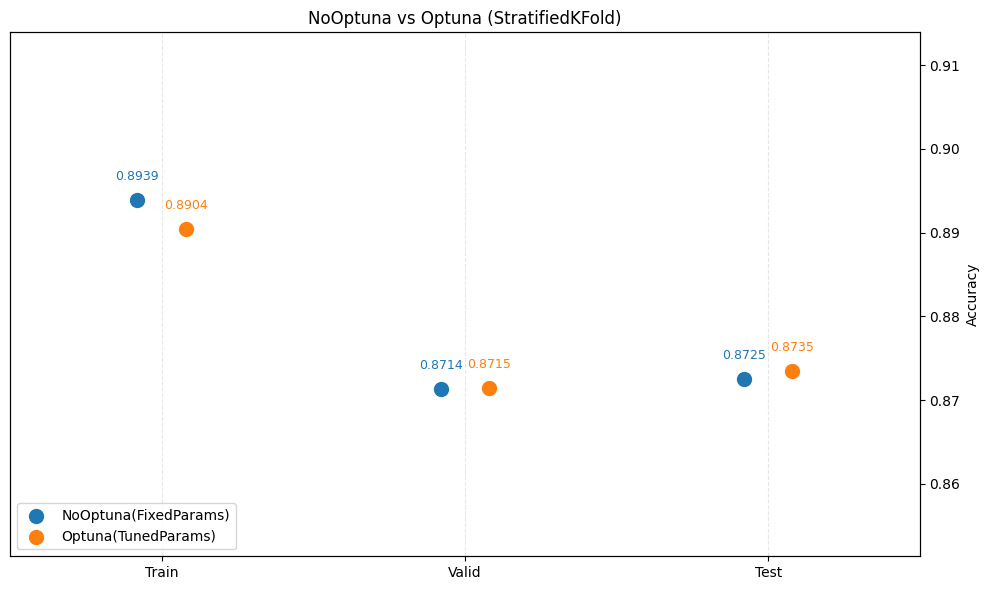

In [81]:
agreement = (baseline_test_pred == optuna_test_pred).mean()
print(f'Test prediction agreement (NoOptuna vs Optuna): {agreement:.4f}')

split_order = ['Train', 'Valid', 'Test']
x = np.arange(len(split_order))
offset = 0.08

acc_no = [pivot_acc.loc[s, 'NoOptuna(FixedParams)'] for s in split_order]
acc_opt = [pivot_acc.loc[s, 'Optuna(TunedParams)'] for s in split_order]

fig, ax = plt.subplots(figsize=(10, 6))
ax_right = ax.twinx()

ax.set_xlim(-0.5, len(split_order) - 0.5)
ax.set_xticks(x)
ax.set_xticklabels(split_order)
ax.set_yticks([])
ax.set_ylabel('')
ax.grid(axis='x', linestyle='--', alpha=0.3)

ax_right.scatter(x - offset, acc_no, s=100, label='NoOptuna(FixedParams)', color='tab:blue')
ax_right.scatter(x + offset, acc_opt, s=100, label='Optuna(TunedParams)', color='tab:orange')

for i, score in enumerate(acc_no):
    ax_right.text(x[i] - offset, score + 0.002, f'{score:.4f}', ha='center', va='bottom', fontsize=9, color='tab:blue')
for i, score in enumerate(acc_opt):
    ax_right.text(x[i] + offset, score + 0.002, f'{score:.4f}', ha='center', va='bottom', fontsize=9, color='tab:orange')

all_acc = np.array(acc_no + acc_opt)
ax_right.set_ylabel('Accuracy')
ax_right.set_ylim(max(0.0, all_acc.min() - 0.02), min(1.0, all_acc.max() + 0.02))
ax_right.legend(loc='lower left')  

plt.title('NoOptuna vs Optuna (StratifiedKFold)')
plt.tight_layout()
plt.show()